In [8]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import matplotlib.pyplot as plt
from dsa_analysis import Simulation, combine_simulations, visualize, visualize_simple, load_config
import DSA
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS
import numpy as np
from itertools import permutations
import similarity
import copy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

We simulate with $num\_samples$ possible initializations accross $num\_steps$ 

Parameters to compute the dissimilarity matrices and the Procrustes Alignment over Vector Fields, according to [1]

In [2]:
config = load_config('../config.yaml')

# Define parameters
dt = config['simulations']['dt']
num_steps = config['simulations']['num_steps']
num_samples = config['simulations']['num_samples']
lorenz_parameters = config['simulations']['lorenz_parameters']
perturbation_scale = config['simulations']['perturbations']

## Similarity vs epochs

We here want to analyse the evolution of the dissimilarity as a function of the epochs

### basic network geometries

Here are the basic patterns

In [3]:
simulation_curve = Simulation(num_samples, num_steps, dt)
pattern_curve = lorenz_parameters['one_attractor'][1]
simulation_curve.simulation_lorenz(pattern_curve)

simulation_two_stable_0 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters['two_stable_attractors'][0]
simulation_two_stable_0.simulation_lorenz(pattern_two_stable)

simulation_two_stable_1 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters["two_stable_attractors"][1]
simulation_two_stable_1.simulation_lorenz(pattern_two_stable)

simulation_two_stable_2 = Simulation(num_samples, num_steps, dt)
pattern_two_stable = lorenz_parameters["two_stable_attractors"][2]
simulation_two_stable_2.simulation_lorenz(pattern_two_stable)

simulation_two_unstable_0 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][0]
simulation_two_unstable_0.simulation_lorenz(pattern_two_unstable)

simulation_two_unstable_1 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][1]
simulation_two_unstable_1.simulation_lorenz(pattern_two_unstable)

simulation_two_unstable_2 = Simulation(num_samples, num_steps, dt)
pattern_two_unstable = lorenz_parameters["two_unstable_attractors"][2]
simulation_two_unstable_2.simulation_lorenz(pattern_two_unstable)

simulations = {
    "curve": simulation_curve,
    "two_stable_0": simulation_two_stable_0,
    "two_stable_1": simulation_two_stable_1,
    "two_stable_2": simulation_two_stable_2,
    "two_unstable_0": simulation_two_unstable_0,
    "two_unstable_1": simulation_two_unstable_1,
    "two_unstable_2": simulation_two_unstable_2,
}

In [4]:
combined_simulations = {pattern1:{pattern2:{model:{epoch:None for epoch in ['epoch1','epoch2','epoch3']} for model in ['model1','model2','model3']} for pattern2 in simulations.keys() if pattern2 != pattern1} for pattern1 in simulations.keys()}

We now add some perturbations to these patterns. For each pattern, we create $3$ networks, each simulated over $3$ epochs : 
- Pattern + Noise 1 (the Noise strenght get weaker as we move towards later epochs)
- Pattern + Noise 2 (Different Noise levels, but same trend)
- Pattern + Noise 3 + Curve

In [5]:
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        if pattern1 != pattern2:
            for model in combined_simulations[pattern1][pattern2]:
                for epoch in combined_simulations[pattern1][pattern2][model]:
                    simulations[pattern1].perturbation(
                        perturbation_scale=perturbation_scale[model][epoch],
                        model=model,
                        epoch=epoch,
                    )
                    combined_simulations[pattern1][pattern2][model][epoch] = copy.deepcopy(simulations[
                        pattern1
                    ].perturbations_record[model][epoch])
                    if model == 'model3':
                        # add the line attractor
                        if epoch == 'epoch1':
                            mixing_level = 1
                        elif epoch=='epoch2':
                            mixing_level = 0.5
                        elif epoch == 'epoch3':
                            mixing_level = 0
                        combined_simulations[pattern1][pattern2][model][epoch] = combine_simulations([copy.deepcopy(simulations[pattern2].simulation),copy.deepcopy(simulations[pattern1].perturbations_record[model][epoch])], method='combine',mixing_level=mixing_level)

### Visualization of random network

We here visualize the 3rd network of the pattern $\text {\it{two stable Lorenz attractors}}$

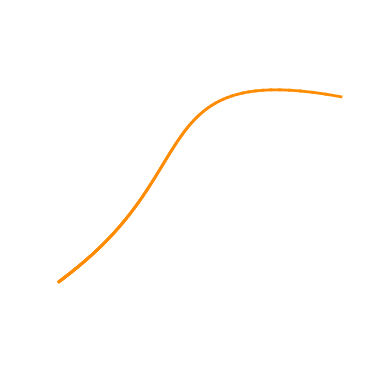

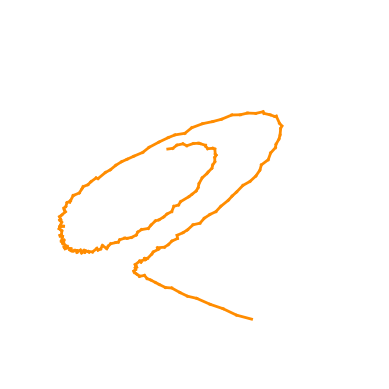

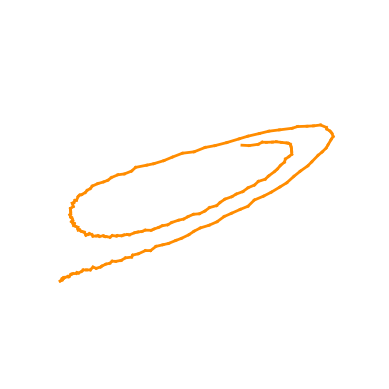

In [12]:
# Visualize the simulations model 1
visualize_simple([combined_simulations["two_stable_1"]["curve"]["model3"][epoch][50] for epoch in ['epoch1','epoch2','epoch3']], color="darkorange")

In [ ]:
combined_simulations["curve"]["two_stable_0"]["model3"]["epoch1"].shape

(200, 200, 3)

### We now want to compare the dissimilarity matrices for the 3 networks

In [ ]:
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_dsa = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        print(f"pattern1: {pattern1}, pattern2: {pattern2}")
        dsa1vs2_epoch1 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch1 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch1"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa1vs2_epoch2 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch2 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch2"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa1vs2_epoch3 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model1"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        dsa2vs3_epoch3 = DSA.DSA(
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch3"],
            n_delays=config["dsa"]["n_delays"],
            rank=config["dsa"]["rank"],
            delay_interval=config["dsa"]["delay_interval"],
            verbose=True,
            iters=1000,
            lr=1e-2,
        )
        vector_1vs2 = np.array([dsa1vs2_epoch1.fit_score(), dsa1vs2_epoch2.fit_score(), dsa1vs2_epoch3.fit_score()])
        vector_2vs3 = np.array([dsa2vs3_epoch1.fit_score(), dsa2vs3_epoch2.fit_score(), dsa2vs3_epoch3.fit_score()])
        vectors_dsa[pattern1][pattern2]['vector1'] = vector_1vs2
        vectors_dsa[pattern1][pattern2]["vector2"] = vector_2vs3

pattern1: curve, pattern2: two_stable_0
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C


KeyboardInterrupt: 

In [ ]:
# For each attractor, pattern compute the 6 DSA between the 3 models
# For each attractor, pattern compute the 6 DSA between the 3 models
vectors_pa = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        pa1vs2_epoch1 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch1'], combined_simulations[pattern1][pattern2]['model2']['epoch1'])
        pa2vs3_epoch1 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch1'], combined_simulations[pattern1][pattern2]['model3']['epoch1'])
        pa1vs2_epoch2 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch2'], combined_simulations[pattern1][pattern2]['model2']['epoch2'])
        pa2vs3_epoch2 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch2'], combined_simulations[pattern1][pattern2]['model3']['epoch2'])
        pa1vs2_epoch3 = procrustes_measure(combined_simulations[pattern1][pattern2]['model1']['epoch3'], combined_simulations[pattern1][pattern2]['model2']['epoch3'])
        pa2vs3_epoch3 = procrustes_measure(combined_simulations[pattern1][pattern2]['model2']['epoch3'], combined_simulations[pattern1][pattern2]['model3']['epoch3'])
        vector_1vs2 = 1-np.array([pa1vs2_epoch1, pa1vs2_epoch2, pa1vs2_epoch3])
        vector_2vs3 = 1-np.array([pa2vs3_epoch1, pa2vs3_epoch2, pa2vs3_epoch3])
        vectors_pa[pattern1][pattern2]['vector1'] = vector_1vs2
        vectors_pa[pattern1][pattern2]["vector2"] = vector_2vs3

In [ ]:
vectors_cka = {
    pattern1: {
        pattern2: {"vector1": None, "vector2": None}
        for pattern2 in combined_simulations[pattern1]
    }
    for pattern1 in combined_simulations
}
cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
for pattern1 in combined_simulations:
    for pattern2 in combined_simulations[pattern1]:
        pa1vs2_epoch1 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
        )
        pa2vs3_epoch1 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch1"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch1"],
        )
        pa1vs2_epoch2 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
        )
        pa2vs3_epoch2 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch2"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch2"],
        )
        pa1vs2_epoch3 = cka_measure(
            combined_simulations[pattern1][pattern2]["model1"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
        )
        pa2vs3_epoch3 = cka_measure(
            combined_simulations[pattern1][pattern2]["model2"]["epoch3"],
            combined_simulations[pattern1][pattern2]["model3"]["epoch3"],
        )
        vector_1vs2 = 1 - np.array([pa1vs2_epoch1, pa1vs2_epoch2, pa1vs2_epoch3])
        vector_2vs3 = 1 - np.array([pa2vs3_epoch1, pa2vs3_epoch2, pa2vs3_epoch3])
        vectors_cka[pattern1][pattern2]["vector1"] = vector_1vs2
        vectors_cka[pattern1][pattern2]["vector2"] = vector_2vs3

arccos score: 0.9979205717522565 0.06450037702120837 0.002079428247743542
arccos score: 0.33552664399232857 1.228632100485969 0.6644733560076714
arccos score: 0.9994799402535606 0.03225228146085739 0.0005200597464394274
arccos score: 0.24254353026515407 1.3258095151363765 0.7574564697348459
arccos score: 0.9998699796908882 0.016125949693353965 0.00013002030911180018
arccos score: 0.9998693924709471 0.01616232484554015 0.0001306075290529174
arccos score: 0.9979113984763602 0.06464253973300527 0.002088601523639766
arccos score: 0.1276850192910517 1.4427617857396373 0.8723149807089483
arccos score: 0.9994794754096191 0.03226669348698856 0.0005205245903808775
arccos score: 0.429974805512368 1.126331455833904 0.570025194487632
arccos score: 0.9998699507664555 0.016127743328985724 0.000130049233544538
arccos score: 0.9998697459692809 0.01614043732386035 0.00013025403071909025
arccos score: 0.9979375566849438 0.06423632384607314 0.0020624433150562282
arccos score: 0.25870430680704093 1.309115

In [ ]:
vectors_dsa_averaged = {'vector1':None, 'vector2':None}
vectors_dsa_sd = {'vector1':None, 'vector2':None}
vectors_pa_averaged = {'vector1':None, 'vector2':None}
vectors_pa_sd = {'vector1':None, 'vector2':None}
vectors_cka_averaged = {"vector1": None, "vector2": None}
vectors_cka_sd = {"vector1": None, "vector2": None}
for vector in vectors_dsa_averaged:
    vectors_dsa_averaged[vector] = np.mean([vectors_dsa[pattern1][pattern2][vector] for pattern1 in vectors_dsa for pattern2 in vectors_dsa[pattern1]], axis=0)
    vectors_dsa_sd[vector] = np.std(
        [
            vectors_dsa[pattern1][pattern2][vector]
            for pattern1 in vectors_dsa
            for pattern2 in vectors_dsa[pattern1]
        ],
        axis=0,
    ) / np.sqrt(
        len([
            vectors_dsa[pattern1][pattern2][vector]
            for pattern1 in vectors_dsa
            for pattern2 in vectors_dsa[pattern1]
        ])
    )
    vectors_pa_averaged[vector] = np.mean(
        [
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ],
        axis=0,
    )
    vectors_pa_sd[vector] = np.std(
        [
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ],
        axis=0,
    ) / np.sqrt(
        len([
            vectors_pa[pattern1][pattern2][vector]
            for pattern1 in vectors_pa
            for pattern2 in vectors_pa[pattern1]
        ])
    )
    vectors_cka_averaged[vector] = np.mean(
        [
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ],
        axis=0,
    )
    vectors_cka_sd[vector] = np.std(
        [
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ],
        axis=0,
    )/np.sqrt(
        len([
            vectors_cka[pattern1][pattern2][vector]
            for pattern1 in vectors_cka
            for pattern2 in vectors_cka[pattern1]
        ])
    )

In [ ]:
vectors_pa_sd['vector1']

array([0.00272285, 0.00136666, 0.00068376])

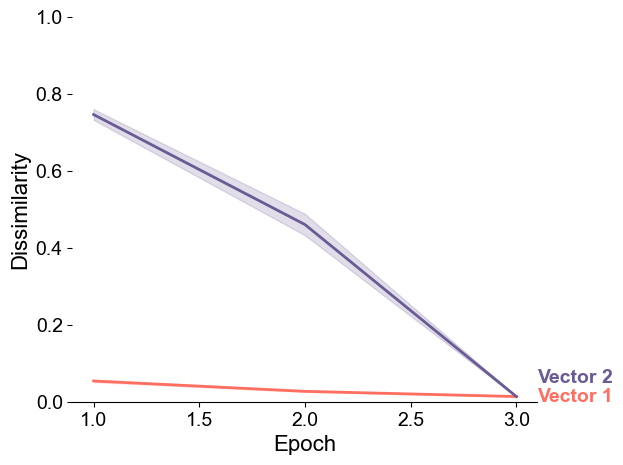

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Indices for each component (Epochs)
components = np.array([1, 2, 3])

# Define color scheme
colors = ["#FF6F61", "#6B5B95"]  # Coral and Slate Blue colors

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot for Vector 1 with shaded area for standard error
ax.plot(
    components,
    vectors_pa_averaged["vector1"],
    color=colors[0],  # Coral color
    label="Vector 1",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_pa_averaged["vector1"] - vectors_pa_sd["vector1"],
    vectors_pa_averaged["vector1"] + vectors_pa_sd["vector1"],
    color=colors[0],
    alpha=0.2,  # Transparency of the shaded area
)

# Plot for Vector 2 with shaded area for standard error
ax.plot(
    components,
    vectors_pa_averaged["vector2"],
    color=colors[1],  # Slate Blue color
    label="Vector 2",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_pa_averaged["vector2"] - vectors_pa_sd["vector2"],
    vectors_pa_averaged["vector2"] + vectors_pa_sd["vector2"],
    color=colors[1],
    alpha=0.2,  # Transparency of the shaded area
)

# Annotate each curve with its label slightly to the right of the last point
vertical_offsets = [0, 0.05]  # Adjust these to space out the labels vertically
for i, (label, color, offset) in enumerate(
    zip(["Vector 1", "Vector 2"], colors, vertical_offsets)
):
    x_last = components[-1]
    y_last = [vectors_pa_averaged["vector1"][-1], vectors_pa_averaged["vector2"][-1]][i]
    ax.text(
        x_last + 0.1,  # Adjust x position slightly to the right
        y_last + offset,
        label,
        color=color,
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Set axis labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Dissimilarity")

# Customize plot limits
ax.set_ylim(0, 1)
ax.set_xlim(0.9, 3.1)  # To ensure space on the right side of the plot for labels

# Hide all but the bottom and left spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_procrustes_vs_epochs_shaded.png", dpi=300)
plt.show()

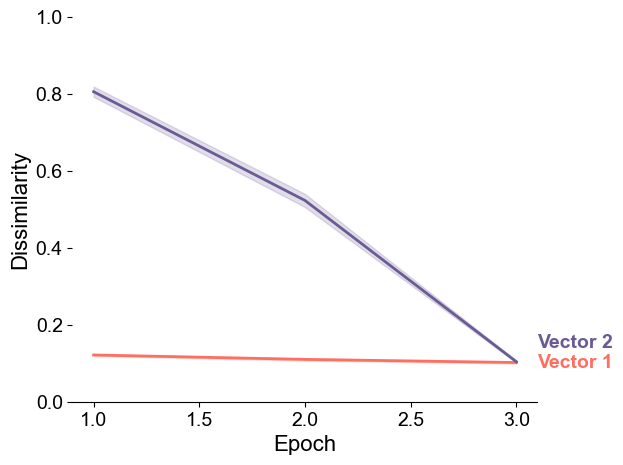

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Indices for each component (Epochs)
components = np.array([1, 2, 3])

# Define color scheme
colors = ["#FF6F61", "#6B5B95"]  # Coral and Slate Blue colors

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot for Vector 1 with shaded area for standard error
ax.plot(
    components,
    vectors_dsa_averaged["vector1"],
    color=colors[0],  # Coral color
    label="Vector 1",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_dsa_averaged["vector1"] - vectors_dsa_sd["vector1"],
    vectors_dsa_averaged["vector1"] + vectors_dsa_sd["vector1"],
    color=colors[0],
    alpha=0.2,  # Transparency of the shaded area
)

# Plot for Vector 2 with shaded area for standard error
ax.plot(
    components,
    vectors_dsa_averaged["vector2"],
    color=colors[1],  # Slate Blue color
    label="Vector 2",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_dsa_averaged["vector2"] - vectors_dsa_sd["vector2"],
    vectors_dsa_averaged["vector2"] + vectors_dsa_sd["vector2"],
    color=colors[1],
    alpha=0.2,  # Transparency of the shaded area
)

# Annotate each curve with its label slightly to the right of the last point
vertical_offsets = [0, 0.05]  # Adjust these to space out the labels vertically
for i, (label, color, offset) in enumerate(
    zip(["Vector 1", "Vector 2"], colors, vertical_offsets)
):
    x_last = components[-1]
    y_last = [vectors_dsa_averaged["vector1"][-1], vectors_dsa_averaged["vector2"][-1]][i]
    ax.text(
        x_last + 0.1,  # Adjust x position slightly to the right
        y_last + offset,
        label,
        color=color,
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Set axis labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Dissimilarity")

# Customize plot limits
ax.set_ylim(0, 1)
ax.set_xlim(0.9, 3.1)  # To ensure space on the right side of the plot for labels

# Hide all but the bottom and left spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_procrustes_vs_epochs_shaded.png", dpi=300)
plt.show()

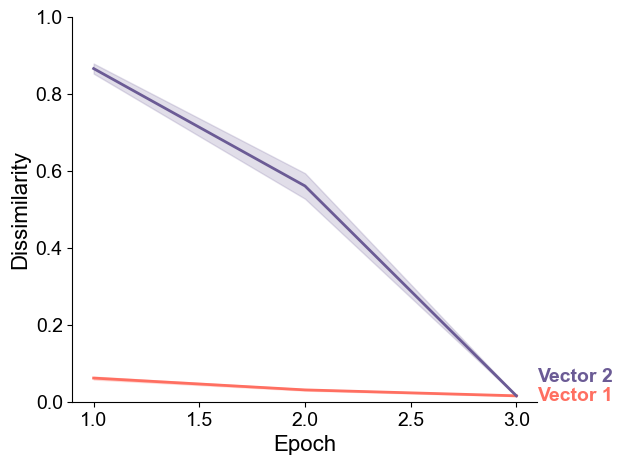

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Indices for each component (Epochs)
components = np.array([1, 2, 3])

# Define color scheme
colors = ["#FF6F61", "#6B5B95"]  # Coral and Slate Blue colors

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot for Vector 1 with shaded area for standard error
ax.plot(
    components,
    vectors_cka_averaged["vector1"],
    color=colors[0],  # Coral color
    label="Vector 1",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_cka_averaged["vector1"] - vectors_cka_sd["vector1"],
    vectors_cka_averaged["vector1"] + vectors_cka_sd["vector1"],
    color=colors[0],
    alpha=0.2,  # Transparency of the shaded area
)

# Plot for Vector 2 with shaded area for standard error
ax.plot(
    components,
    vectors_cka_averaged["vector2"],
    color=colors[1],  # Slate Blue color
    label="Vector 2",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_cka_averaged["vector2"] - vectors_cka_sd["vector2"],
    vectors_cka_averaged["vector2"] + vectors_cka_sd["vector2"],
    color=colors[1],
    alpha=0.2,  # Transparency of the shaded area
)

# Annotate each curve with its label slightly to the right of the last point
vertical_offsets = [0, 0.05]  # Adjust these to space out the labels vertically
for i, (label, color, offset) in enumerate(
    zip(["Vector 1", "Vector 2"], colors, vertical_offsets)
):
    x_last = components[-1]
    y_last = [vectors_cka_averaged["vector1"][-1], vectors_cka_averaged["vector2"][-1]][i]
    ax.text(
        x_last + 0.1,  # Adjust x position slightly to the right
        y_last + offset,
        label,
        color=color,
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Set axis labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Dissimilarity")

# Customize plot limits
ax.set_ylim(0, 1)
ax.set_xlim(0.9, 3.1)  # To ensure space on the right side of the plot for labels

# Hide all but the bottom and left spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_procrustes_vs_epochs_shaded.png", dpi=300)
plt.show()

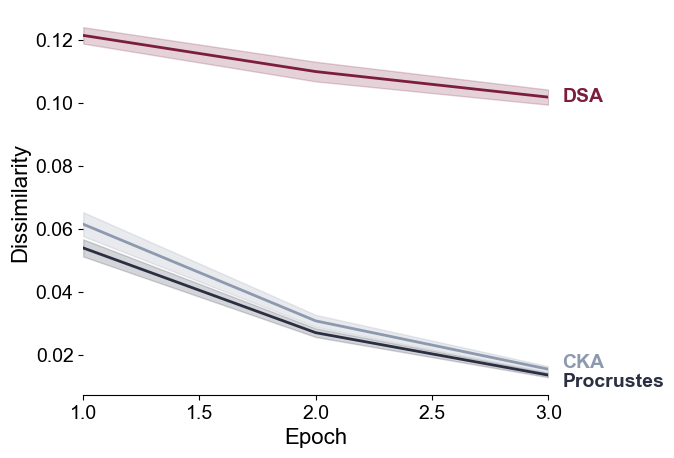

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Indices for each component (Epochs)
components = np.array([1, 2, 3])

# Define color scheme
colors = [
    "#7B1E3C",
    "#8D99AE",
    "#2B2F42",
]  # Greys for CKA and Procrustes, Red for DSA

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot for Vector 1 with shaded area for standard error
ax.plot(
    components,
    vectors_dsa_averaged["vector1"],
    color=colors[0],  # Coral color
    label="Vector 1",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_dsa_averaged["vector1"] - vectors_dsa_sd["vector1"],
    vectors_dsa_averaged["vector1"] + vectors_dsa_sd["vector1"],
    color=colors[0],
    alpha=0.2,  # Transparency of the shaded area
)

# Plot for Vector 2 with shaded area for standard error
ax.plot(
    components,
    vectors_cka_averaged["vector1"],
    color=colors[1],  # Slate Blue color
    label="Vector 1",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_cka_averaged["vector1"] - vectors_cka_sd["vector1"],
    vectors_cka_averaged["vector1"] + vectors_cka_sd["vector1"],
    color=colors[1],
    alpha=0.2,  # Transparency of the shaded area
)

# Plot for Vector 2 with shaded area for standard error
ax.plot(
    components,
    vectors_pa_averaged["vector1"],
    color=colors[2],  # Slate Blue color
    label="Vector 1",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_pa_averaged["vector1"] - vectors_pa_sd["vector1"],
    vectors_pa_averaged["vector1"] + vectors_pa_sd["vector1"],
    color=colors[2],
    alpha=0.2,  # Transparency of the shaded area
)

# Annotate each curve with its label slightly to the right of the last point
vertical_offsets = [0, 0.002,-0.002]  # Adjust these to space out the labels vertically
for i, (label, color, offset) in enumerate(
    zip(["DSA", "CKA", "Procrustes"], colors, vertical_offsets)
):
    x_last = components[-1]
    y_last = [
        vectors_dsa_averaged["vector1"][-1],
        vectors_cka_averaged["vector1"][-1],
        vectors_pa_averaged["vector1"][-1],
    ][i]
    ax.text(
        x_last*1.02,  # Adjust x position slightly to the right
        y_last+offset,
        label,
        color=color,
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Set axis labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Dissimilarity")

# Customize plot limits
ax.set_xlim(1, 3)  # To ensure space on the right side of the plot for labels

# Hide all but the bottom and left spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_procrustes_vs_epochs_shaded.png", dpi=300)
plt.show()

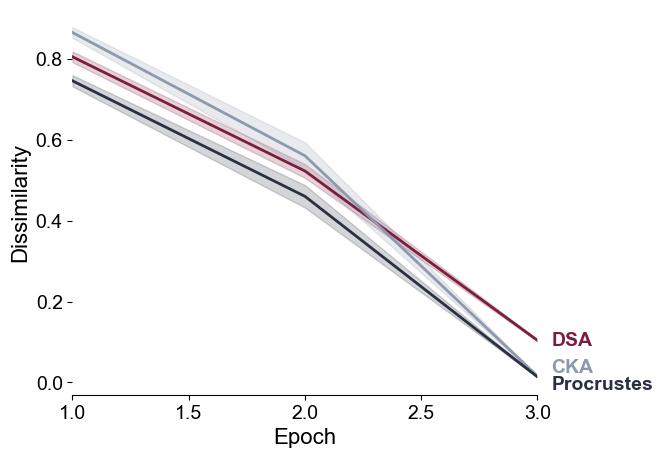

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", family="Arial")  # controls default font
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

# Indices for each component (Epochs)
components = np.array([1, 2, 3])

# Define color scheme
colors = [
    "#7B1E3C",
    "#8D99AE",
    "#2B2F42",
]  # Greys for CKA and Procrustes, Red for DSA

# Create the plot
fig, ax = plt.subplots(figsize=(6, 5))

# Plot for Vector 1 with shaded area for standard error
ax.plot(
    components,
    vectors_dsa_averaged["vector2"],
    color=colors[0],  # Coral color
    label="Vector 2",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_dsa_averaged["vector2"] - vectors_dsa_sd["vector2"],
    vectors_dsa_averaged["vector2"] + vectors_dsa_sd["vector2"],
    color=colors[0],
    alpha=0.2,  # Transparency of the shaded area
)

# Plot for Vector 2 with shaded area for standard error
ax.plot(
    components,
    vectors_cka_averaged["vector2"],
    color=colors[1],  # Slate Blue color
    label="Vector 2",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_cka_averaged["vector2"] - vectors_cka_sd["vector2"],
    vectors_cka_averaged["vector2"] + vectors_cka_sd["vector2"],
    color=colors[1],
    alpha=0.2,  # Transparency of the shaded area
)

# Plot for Vector 2 with shaded area for standard error
ax.plot(
    components,
    vectors_pa_averaged["vector2"],
    color=colors[2],  # Slate Blue color
    label="Vector 2",
    linewidth=2,
)

# Fill between for standard error (shaded area)
ax.fill_between(
    components,
    vectors_pa_averaged["vector2"] - vectors_pa_sd["vector2"],
    vectors_pa_averaged["vector2"] + vectors_pa_sd["vector2"],
    color=colors[2],
    alpha=0.2,  # Transparency of the shaded area
)

# Annotate each curve with its label slightly to the right of the last point
vertical_offsets = [0, 0.02, -0.02]  # Adjust these to space out the labels vertically
for i, (label, color, offset) in enumerate(
    zip(["DSA", "CKA", "Procrustes"], colors, vertical_offsets)
):
    x_last = components[-1]
    y_last = [
        vectors_dsa_averaged["vector2"][-1],
        vectors_cka_averaged["vector2"][-1],
        vectors_pa_averaged["vector2"][-1],
    ][i]
    ax.text(
        x_last * 1.02,  # Adjust x position slightly to the right
        y_last + offset,
        label,
        color=color,
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )

# Set axis labels
ax.set_xlabel("Epoch")
ax.set_ylabel("Dissimilarity")

# Customize plot limits
ax.set_xlim(1, 3)  # To ensure space on the right side of the plot for labels

# Hide all but the bottom and left spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

# Save the plot as a high-resolution image
plt.savefig("dissimilarity_procrustes_vs_epochs_shaded.png", dpi=300)
plt.show()

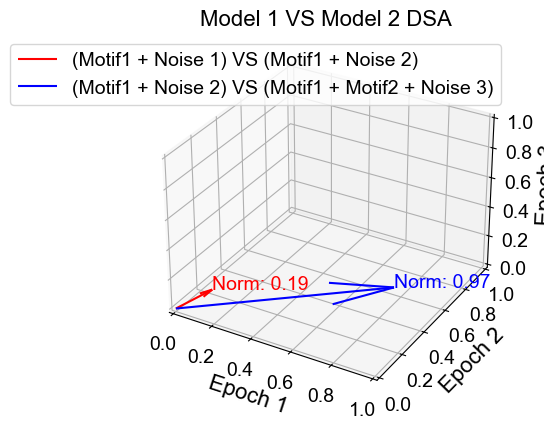

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Function to plot vectors in 3D
def plot_vectors(vector1, vector2, title, xlabel='Epoch 1', ylabel='Epoch 2', zlabel='Epoch 3'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.quiver(0, 0, 0, vector1[0], vector1[1], vector1[2], color='r', label='(Motif1 + Noise 1) VS (Motif1 + Noise 2)'.format(title,title))
    ax.quiver(0, 0, 0, vector2[0], vector2[1], vector2[2], color='b', label='(Motif1 + Noise 2) VS (Motif1 + Motif2 + Noise 3)'.format(title, title))

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    ax.text(vector1[0], vector1[1], vector1[2], f'Norm: {norm1:.2f}', color='r')
    ax.text(vector2[0], vector2[1], vector2[2], f'Norm: {norm2:.2f}', color='b')

    plt.title(title)
    ax.legend()
    plt.show()


plot_vectors(vectors_dsa_averaged['vector1'], vectors_dsa_averaged['vector2'], title='Model 1 VS Model 2 DSA')

## References

[1]: Mitchell Ostrow, Adam Eisen, Leo Kozachkov, Ila Fiete, "Beyond Geometry: Comparing the Temporal Structure of Computation in Neural Circuits with Dynamical Similarity Analysis", 	arXiv:2306.10168
 